# Researching & Developing a Market Neutral Strategy - Case Study - USD-EUR Exchange Rate

The following notebook aims to demonstrate best practices when developing a market-neutral signal based on Quantopian's data feeds. Following the steps detailed in [this post](https://www.quantopian.com/posts/using-alternative-data-researching-and-implementing-a-market-neutral-strategy) and demonstrated in this notebook will ensure a well-founded alternative data signal that stands a better chance of holding up during out-of-sample validation and live trading.

### Intro - Why use Alternative Data?
Fundamental asset data such as price, volume, or company financials has many benefits including its accessibility and simplicity. However, these advantages are a double-edged sword as any "alpha" left in these datasets can be especially difficult to extract exactly because of the amount of people using the data. 

Because alternative data streams are not as widely available or as easy to use as fundamental ones, finding novel information that has yet to be "priced in" by the market is easier. Further benefits include the tendency for alternative data signals to be uncorrelated to ones based on traditional data.

Some of the major drawbacks of alternative data include its lack of structure, cost, exclusivity, and high dimensionality. Luckily, Quantopian takes down some of these barriers through its [wide variety of alternative data feeds](https://www.quantopian.com/data/), many of which are free to use and all of which have been cleaned and standardized to work both in pipeline and as interactive datasets in the research environment.

### Abstract

Through some preliminary research (reading papers, exploring data) we arrive at a hypothesis we would like to test. [This paper](http://www.nber.org/papers/w13090.pdf) by Lamont et al. shows that stocks trade at a premium around their earnings announcement, however the testing sample only goes up to 2004. Let's find out if the premium has survived past then.

** Hypothesis: ** *This anomaly of inflated prices around earnings announcements, observed before 2004 in Lamont et al., is still present today.*

To test it we: 

1) Examine the data using Blaze and look at the effects of earnings announcements on a single asset.

2) Use pipeline to filter a universe of assets and look for earnings announcement premia across all assets.

3) Use Alphalens to examine the strength of our signal within the in-sample period.

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import blaze as bz
import math
import numpy as np
import seaborn
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa as tsa

from statsmodels import regression
from odo import odo

# Researching Alternative Data: Earnings Calendar
The earnings calendar data used in this notebook, as well as the Morningstar fundamental data, are all available as free datafeeds. 

** Hypothesis: ** *This anomaly of inflated prices around earnings announcements, observed before 2004 in Lamont et al., is still in more recent years.*

In [32]:
# Importing exchange rate data set
# When importing for blaze/non-pipeline research use quantopian.interactive._
# When importing for pipeline use quantopian.pipeline._
from quantopian.interactive.data.eventvestor import earnings_calendar

print len(earnings_calendar), 'rows of data'

126453 rows of data


This size of this dataset exceeds the 10,000 row limit allowed by Quantopian's data agreements. What this means is that we cannot pull it all into a Pandas dataframe directly, and instead must use Blaze to perform computations remotely, before using `bz.compute` to pull results (which should be smaller than 10,000 rows).

This earnings calendar datset begins in 2007 but has more complete data from 2008 on, so taking this into account we will set our research period as 2008-2011. This range is large enough to observe most trends but small enough to leave room for thorough out-of-sample testing.

Because we cannot pull the whole interactive dataset, let's instead pull the earnings calendar for just General Electric.

In [33]:
# Defining our asset and test range
asset = 'GE'
start = '2008-01-01'
end = '2012-01-01'

# Pulling pricing data for GE
pricing = get_pricing(asset, start_date=start, end_date=end)

# Selecting earnings dates for GE and computing the Blaze expression into a Pandas DataFrame
calendar_expression = earnings_calendar['asof_date'][earnings_calendar['symbol']==asset]
calendar = bz.compute(calendar_expression)

# Slicing earnings dates to within our test range
calendar = pd.to_datetime(calendar[(calendar>start)&(calendar<end)].values, utc=True)
print 'Earnings announcements for',asset,':\n\n',calendar

Earnings announcements for GE :

DatetimeIndex(['2008-01-18', '2008-04-11', '2008-07-11', '2008-10-10',
               '2009-01-23', '2009-04-17', '2009-07-10', '2009-10-16',
               '2010-01-22', '2010-04-16', '2010-07-16', '2010-10-15',
               '2011-01-21', '2011-04-21', '2011-07-22', '2011-10-07'],
              dtype='datetime64[ns, UTC]', freq=None)


As one would hope, there seems to be four earnings announcments per year. Let's plot these announcements to see if `GE` price and volume have observable reactions to these earnings announcemnts.

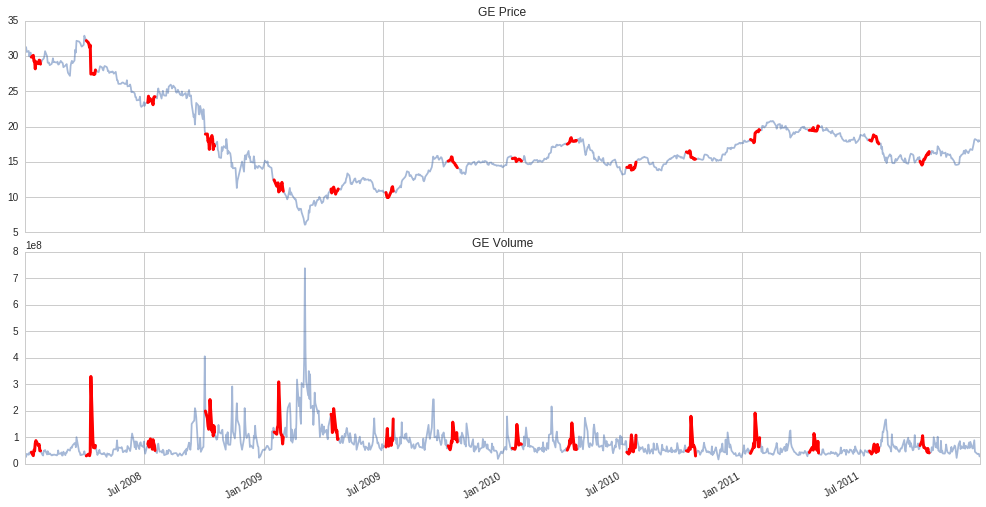

In [34]:
def highlight_events(ts, event_times, window_length, ax=None):

    # Validating axis input
    if ax is None:
        ax = plt.gca()

    # Plotting inputted time series
    ts.plot(ax=ax, alpha = 0.5)
    timedelta = pd.Timedelta((window_length-1)/2, unit='d')

    # Plotting using red within windowed regions
    for event in event_times:
        window = pd.date_range(start = event - timedelta, periods=window_length)
        ax.plot(window, ts[window].interpolate(method='linear'),
                 c='r', linewidth=3)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)

plt.tight_layout()
        
highlight_events(pricing['price'], calendar, 15, ax[0])
highlight_events(pricing['volume'], calendar, 15, ax[1])
ax[0].set_title('%s Price'%asset);
ax[1].set_title('%s Volume'%asset);

There definitely seems to be spikes in volume around earnings announcements, however the effect of these events on price is not observably significant within this specific sample. We can quantify this by comparing mean returns and mean volume inside the earnings widows with mean returns and mean volume from timeregions outside earnings windows.

In [35]:
def compute_event_function(ts, event_times, window_length, function):
    
    # Defining variables used to find window indices
    indices_in_window = pd.DatetimeIndex(event_times)
    timedelta = pd.Timedelta((window_length-1)/2, unit='d')
    
    # Appending indices in windows to list
    for event in event_times:
        indices_in_window = indices_in_window.append(pd.date_range(start = event - timedelta, 
                                                                   periods=window_length))
    
    # Returning function output with input of ts within windows
    return function(ts[indices_in_window])

not_earnings_window = pricing.index[~pricing.index.isin(calendar)]

print 'Avg returns in window:', compute_event_function(pricing['price'].pct_change(), calendar, 15, np.mean)
print 'Avg returns out of window:', np.mean(pricing['price'].pct_change()[not_earnings_window])

print '\nAvg volume in window:', compute_event_function(pricing['volume'], calendar, 15, np.mean)
print 'Avg volume out of window:', np.mean(pricing['volume'][not_earnings_window])

Avg returns in window: -0.00248359004906
Avg returns out of window: 7.22042088041e-05

Avg volume in window: 90682011.4076
Avg volume out of window: 74918192.5619


These results back up what we saw in the graph, as volume is measurably higher and returns are about even, if not lower than in the periods outside of the earnings windows. However, this is a small sample and we will need to conduct further testing across the whole universe of equities.

# Designing a Pipeline

Building a [pipeline](https://www.quantopian.com/tutorials/pipeline) will make pulling in earnings calendar data much easier. There exists built-in factors for this dataset, `BusinessDaysUntilNextEarnings` and `BusinessDaysSincePreviousEarnings`, that will let us skip some steps later on. When we are finished with this stage, the pipeline output can go straight into Alphalens and the pipeline itself can be copied and pasted into the IDE to be used in an algorithm.

In [36]:
# Pipeline API imports
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

# Importing built in factors, universe, and data
from quantopian.pipeline.factors import SimpleMovingAverage, CustomFactor, Returns
from quantopian.pipeline.filters.morningstar import Q1500US, Q500US
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.morningstar import Sector

# Import builtin earnings factor and other data
from quantopian.pipeline.factors.eventvestor import BusinessDaysSincePreviousEarnings
from quantopian.pipeline.data.eventvestor import EarningsCalendar
from quantopian.pipeline.data import morningstar

In [37]:
class NumberOfEAinPastYear(CustomFactor):
    """ Returns the number of earnings days in the past year """
    
    # The specific inputs we need to calculate correlation
    inputs =[EarningsCalendar.previous_announcement]
    window_length = 252
    def compute(self, today, asset_ids, out, earnings):

        EAs = []
        
        for row in earnings.T:
            EAs.append(len(np.unique(row))-1)
        
        out[:] = EAs

In [38]:
# Assigning the Q1500US as our universe
universe = Q500US()

# Creating a filter to ensure all assets in universe have had 4 earnings announcements in the past year
NumEAs = NumberOfEAinPastYear(mask=universe)
ea_filter = NumEAs.eq(4)

# Buildling our pipeline
pipe = Pipeline(
    columns={
        'BDaysSinceEarnings' : BusinessDaysSincePreviousEarnings(mask=universe),
    },
    screen=(universe&ea_filter)
)

result = pd.DataFrame()

start = '2008-01-01'
end = '2012-01-01'

# Stores pipeline in result
result = run_pipeline(pipe, start, end)
assets = result.index.levels[1].unique()

In [39]:
# Finds assets and pricing data
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')
volume = get_pricing(assets, start_date = start, end_date = end, fields = 'volume')

The distribution of maximum days between earnings announcements in the Q1500 US:

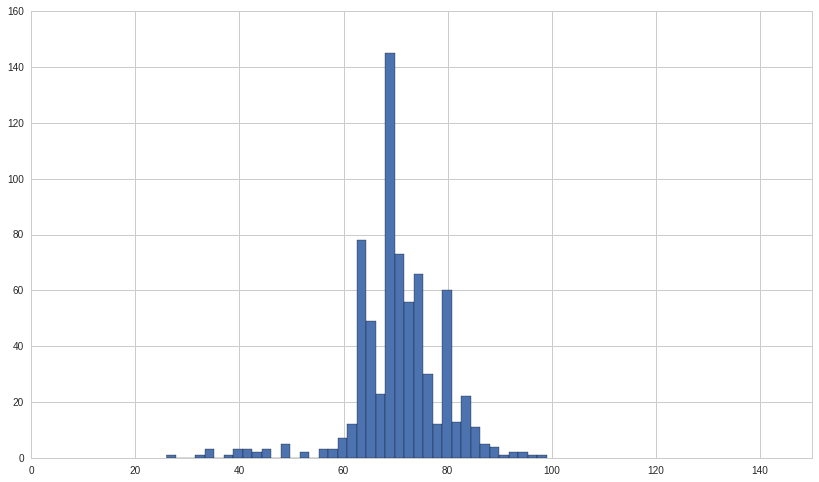

In [40]:
result['BDaysSinceEarnings'].unstack().max(axis=0).hist(bins=40);
plt.xlim(0,150);

This distribution is significant because it shows that many assets have earnings announcements that behave differently than expected. If every equity had earnings announcements exactly once per quarter, the entire distribution would exist between 60 and 90. Instead there are values in the single digits and in the hundreds. This means we cannot make any assumptions about earnings intervals being uniform or regular despite the fact we filtered for assets with 4 earnings announcements within the past year. 

### Daily Approach

To observe the effect of earnings announcements, let's sort all asset-date pricing pairs into buckets based off of how close they are to an earnings announcment. Then, we can assign a window length and see average return across all assets and earnings announcments vs. days before earnings announcment.

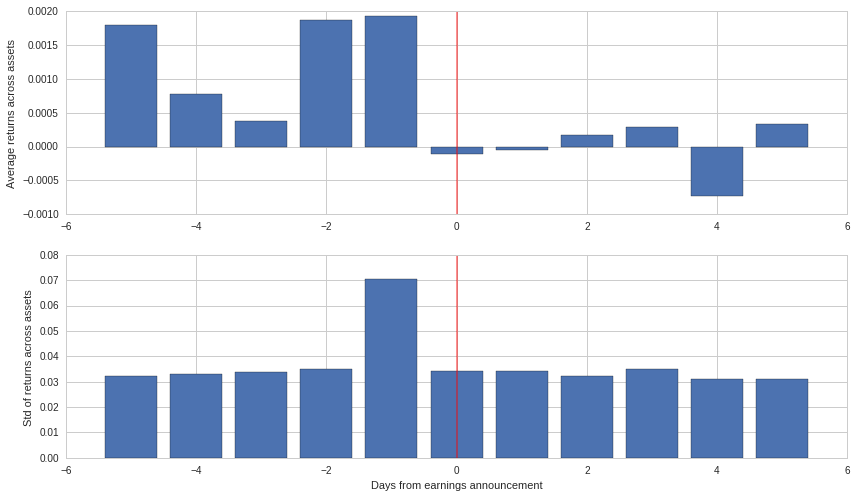

In [41]:
# Length of earnings window, i.e. 11 is 5 business days before to 5 business days after
window_length=11

# Creating a DataFrame to indicate the start of an earnings window
earnings_window_start = result['BDaysSinceEarnings'].unstack().shift(-(window_length-1)/2)==0.0
earnings_window = pd.DataFrame(index = result.unstack().index, columns = assets)
earnings_window[earnings_window_start] = -(window_length-1)/2

counted_window = earnings_window
window_rets_mean = []
window_rets_std = []

# Assigining numbers designating timedelta to earnings for asset-time pairs within earnings window
# Finding averages for each earnings day timedelta from -5 through 5
for i in range(1,window_length + 1):
    counted_window = counted_window.mask(counted_window.isnull(), other=(earnings_window+i).shift(i))
    day_return = pricing.pct_change()[counted_window == -(window_length-1)/2 + i]
    window_rets_mean.append(day_return.stack().mean())
    window_rets_std.append(day_return.stack().std())
    
# Plotting
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].bar(range(-(window_length-1)/2, (window_length-1)/2 + 1), window_rets_mean, align='center');
ax[0].axvline(0, c='r', alpha=0.5);
ax[0].set_ylabel('Average returns across assets');

ax[1].bar(range(-(window_length-1)/2, (window_length-1)/2 + 1), window_rets_std, align='center');
ax[1].axvline(0, c='r', alpha=0.5);
ax[1].set_ylabel('Std of returns across assets');

plt.xlabel('Days from earnings announcement');

Across the Q500, filtered by earnings announcment consistency, there seems to be two significant patterns. The first is that returns are overall positive on average with most of the premium existing before the announcment day. The second is that the largest effect on volume is the day before the earnings announcement, with a standard deviation of returns twice as high as what was observed on other days.

Because we are focusing on the Lamont paper we will continue attempting to prove the same hypothesis from before instead of diving into what we found here. 

### Monthly Approach

Lamont et al. used a different approach to detect earnings announcement premia. For every month in their research period, they compared the returns of a bucket of assets with earnings announcments within that month with the rest of the assets in the universe with no earnings announcements scheduled. The main reasons for this more blunt approach is to accomodate anomalies like early, delayed, or misrepresented earnings announcements.

In [42]:
def get_calendar_window_data(dataframe, freq, events):
    
    dataframe = pd.DataFrame(dataframe)
    events = pd.DataFrame(events)
    
    # Grouping data by calendar months
    calendar_windows = events.groupby(pd.TimeGrouper(freq=freq)).aggregate(np.sum)
    data_by_calendar_group = dataframe.groupby(pd.TimeGrouper(freq=freq)).aggregate(np.nansum)
    
    # Finding statistics for inside vs outside earnings calendar months
    data_in_calendar_window = data_by_calendar_group[calendar_windows.notnull()]
    data_not_in_calendar_window = data_by_calendar_group[calendar_windows.isnull()]
    
    return data_in_calendar_window, data_not_in_calendar_window
    

returns_monthly_window = get_calendar_window_data(pricing.pct_change(), 'MS',
                                                result.unstack()[result.unstack()==0]['BDaysSinceEarnings']
                                                )

In [43]:
print 'Average Monthly Returns:'
print '\nWithin earnings months:', returns_monthly_window[0].stack().mean()
print 'Within non-earnings months:', returns_monthly_window[1].stack().mean()
print 'Difference:', returns_monthly_window[0].stack().mean() - returns_monthly_window[1].stack().mean()

Average Monthly Returns:

Within earnings months: 0.0142593379822
Within non-earnings months: 0.0109416079917
Difference: 0.00331772999051


Across the universe it seems like the earnings announcement premium is present, but small. When assets are within their earnings month, the average monthy returns were 1.4% vs 1.1% when outside earnings months.

Let's evaluate the magnitude of this earnings announcment premium on an asset by asset basis:

In [44]:
asset_earnings_prem = returns_monthly_window[0].mean() - returns_monthly_window[1].mean()

print 'Mean return in earnings months - mean return in non-earnings months:'
asset_earnings_prem.head()

Mean return in earnings months - mean return in non-earnings months:


Equity(2 [ARNC])    -0.045486
Equity(24 [AAPL])    0.028194
Equity(62 [ABT])    -0.004178
Equity(67 [ADSK])   -0.075353
Equity(76 [TAP])    -0.007036
dtype: float64

### Relation to Market Cap

Let's find the 2010 market cap for all assets in our universe and evaluate if it is related to the presence of earnings announcment premium. A finding of the Lamont paper was that large cap equities tended to have the stronges earnings announcement premia.

In [45]:
# Creating pipeline to pull market cap data from Morningstar
# Using 2010 data to represent the whole sample
pipe2 = Pipeline(
    columns={
        'mkt_cap' : morningstar.valuation.market_cap.latest,
    },
    screen=(universe&ea_filter)
)

result2 = run_pipeline(pipe2, '2010-01-01', '2010-01-01')

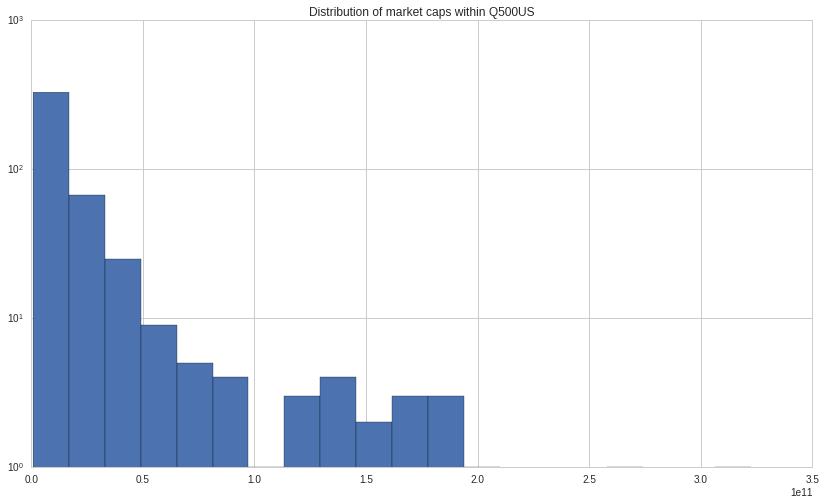

In [46]:
mkt_caps = result2.unstack()['mkt_cap'].mean()
ax = mkt_caps.hist(bins=20, log=True)
ax.set_title('Distribution of market caps within Q500US');

In [47]:
print 'Correlation between mkt_cap and earnings premium:', asset_earnings_prem[mkt_caps.index].corr(mkt_caps)

Correlation between mkt_cap and earnings premium: 0.0466067309196


This experiment does not give evidence of correlation between earnings announcement premium and market cap. Let's see if historical volume predictability is a predictor of earnings anouncement premiums.

### Relation to Volume Predictability

To measure historical volume predictability with respect to earnings announcements, we will find the difference in volume between assets close to their earnings announcements and assets outside of their earnings weeks.

In [48]:
volume_weekly_window = get_calendar_window_data(volume, 'W',
                                                result.unstack()[result.unstack()==0]['BDaysSinceEarnings']
                                                )

earnings_vol_effect = volume_weekly_window[0].mean() - volume_weekly_window[1].mean()
asset_earnings_prem.corr(earnings_vol_effect)

0.071641792598458473

It seems as if historical volume predictability is not correlated with earnings announcement premia.

### Creating Custom Factor

Let's create a custom factor which ranks assets based on volume predictability and long the assets which are within two weeks of an earnings announcements and short those that are not. The magnitude of volume predictability determines long and short weights.

In [49]:
class VolPredictabilityEAP(CustomFactor):
    """ 
    Assigns volume predictability through the ratio of volume within earnings windows to volume outside of
    earnings windows. Then assigns a sign to weights depending on whether asset is in earnings window or
    not.
    """
    inputs =[EarningsCalendar.previous_announcement,
             USEquityPricing.volume]
    window_length = 252
    def compute(self, today, asset_ids, out, earnings_dates, volume):
        
        vp = np.array([])
        
        for i in range(len(asset_ids)):
            earnings_indices = np.where(earnings_dates[:-1, i] != earnings_dates[1:, i])[0]
            window_indices = np.array([],dtype=int)
            
            for j in range(-5,5):
                window_indices = np.append(window_indices, earnings_indices+j)
            
            window_indices = window_indices[(0 <= window_indices) & (window_indices < 252)]
            in_window = volume[window_indices,i].mean()
            out_window = volume[~np.in1d(range(252), window_indices),i].mean()
            
            asset_vp = in_window/out_window
            
            try:
                if (earnings_indices[0] > 5 & earnings_indices[0] < 60):
                    asset_vp = -asset_vp
            except:
                pass
                
            vp = np.append(vp, asset_vp)

        out[:] = vp

In [56]:
universe = Q500US()

NumEAs = NumberOfEAinPastYear(mask=universe)

ea_filter = NumEAs.eq(5)

pipe3 = Pipeline(
    columns={
        'VolPredictability' : VolPredictabilityEAP(mask=universe),
    },
    screen=(universe)
)

result3 = run_pipeline(pipe3, '2008-01-01', '2011-01-01')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In the future, NAT != NAT will be True rather than False.
  from ipykernel import kernelapp as app


# Analyzing our Factor with Alphalens

[Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) will help us evaluate the strength of our factor within the sample. We will use 1, 10, and 30-day return periods as our factor is based on a weekly to monthly time windows between assets and the exchange rate and should therefore be evaluated on a long-term basis.

In [57]:
import alphalens as al

# Formats the factor data, pricing data, and group mappings into a DataFrame 
# necessary for most Alphalens tearsheets.
# We invert the sign of our factor as we want the lowest correlations to have highest weights
# and the highest correlations to have the lowest weights.
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=result3['VolPredictability'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1,10,30))

In [58]:
al.performance.factor_alpha_beta(factor_data)

,1,10,30
Ann. alpha,0.025810,0.011323,-0.004321
beta,0.026556,0.014738,0.006449


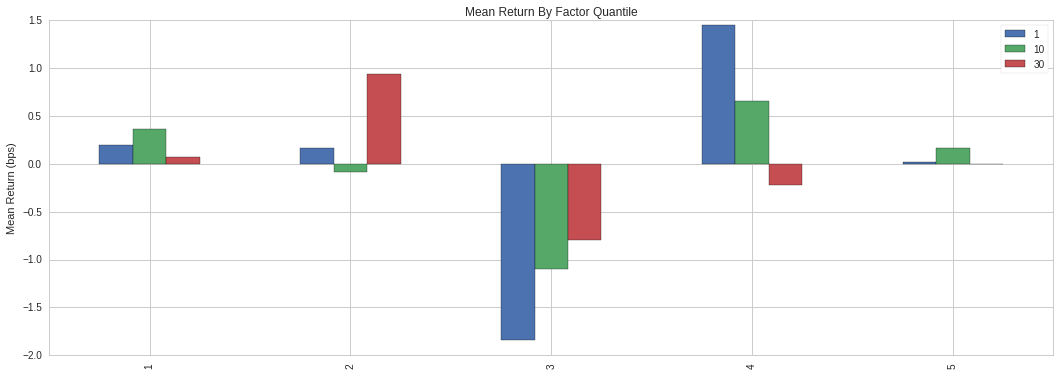

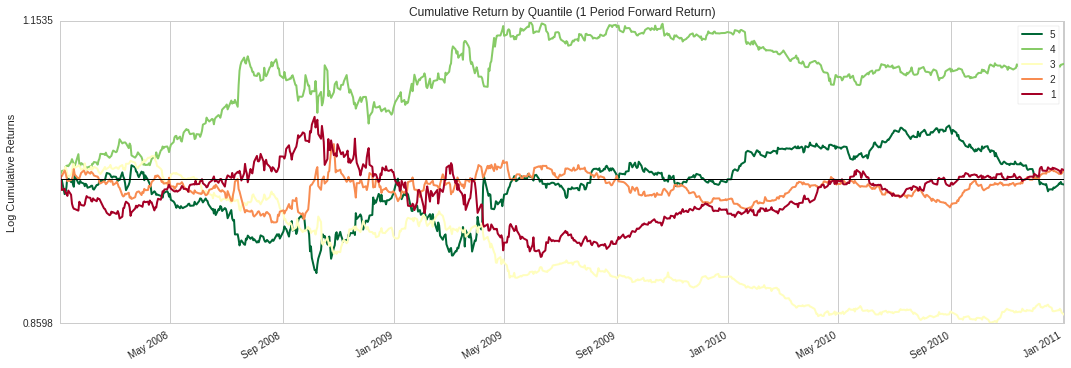

In [59]:
# Use Alphalens to get mean returns by quantile over 1, 10, and 30 day windows
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data, by_group=False)
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data, by_date=True)

al.plotting.plot_quantile_returns_bar(mean_return_by_q.apply(al.utils.rate_of_return, axis=0));
al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period=1);

### Possible Next Steps

* Explore the results from the daily approach, such as the tendency for the bias to be focused around the days before the announcement and not after.
* Test the factor on universes larger than the Q500US and add filters.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*